# Using SunPy in the Cloud: Scalable Solar Data Analysis with `sunpy`, `astropy`, and `dask`

The goal of this notebook is demonstrate how to analyze solar image data.
The Atomospheric Imaging Assembly (AIA) on the Solar Dynamics Observatory (SDO) takes an image of the entire Sun at several extreme ultraviolet (EUV) wavelengths every 12 seconds.
In doing so, AIA images the very hottest part of the solar atmosphere, around 0.5-4 MK.
By analyzing images from AIA as a function of time, we can better understand how plasma in the solar atmosphere is heated.

In this notebook, we will show how to perform a *time-lag analysis* between two wavelengths over the course of a 12 h observing window in order to better understand how the solar coronal plasma is evolving around 1 MK.

In [49]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

import astropy.units as u
import astropy.io.fits
import astropy.time
from astropy.coordinates import SkyCoord
from astropy.visualization import ImageNormalize, AsinhStretch
from reproject import reproject_adaptive
import sunpy.map
import sunpy.util
from sunpy.net import Fido, attrs as a
from sunpy.coordinates import propagate_with_solar_surface
import ndcube
from sunkit_image.time_lag import time_lag

from dask_gateway import Gateway
from dask.distributed import PipInstall
import dask.array

from net.heliocloud import HelioCloudClient
import net.attrs as heliocloud_attrs

## Create Dask Cluster

In [50]:
gateway = Gateway()

In [51]:
options = gateway.cluster_options()
options.worker_cores = 1
options.worker_memory = 8

In [52]:
cluster = gateway.new_cluster(options)

In [53]:
client = cluster.get_client()
client

Connection method: Cluster object,Cluster type: dask_gateway.GatewayCluster
Dashboard: /services/dask-gateway/clusters/daskhub.227a0fa95c044e20a9516eab4e2a95fb/status,


In [54]:
pip_plugin = PipInstall(
    packages=[
        "ndcube",
        "sunpy[map]",
        "astropy",
    ],
    pip_options=["--upgrade"],
)
client.register_worker_plugin(pip_plugin)

{}

In [55]:
cluster.adapt(minimum=3, maximum=100)

## Searching for data

First, define the wavelengths we want to search over and the time range.
We have identified the time interval of interest using the active region on the Sun that we want to study.

In [56]:
interval = 12*u.h
midpoint = astropy.time.Time('2018-05-29 18:00:00', scale='utc')
time_start = midpoint-interval/2
time_end = midpoint+interval/2

To search for data, we can use the `Fido` search interface provided by `sunpy` combined with a custom client developed to search the HelioCloud database.

In [57]:
q = Fido.search(
    a.Time(time_start, time_end),
    a.Wavelength(171*u.angstrom),
    heliocloud_attrs.Dataset('AIA'),
)

In [58]:
q

Dataset,Start time,URL
str3,object,str86
aia,2018-05-29 12:00:00,s3://gov-nasa-hdrl-data1/sdo/aia/20180529/0171/sdo_aia_h2_20180529T120000_0171_v1.fits
aia,2018-05-29 12:04:00,s3://gov-nasa-hdrl-data1/sdo/aia/20180529/0171/sdo_aia_h2_20180529T120400_0171_v1.fits
aia,2018-05-29 12:08:00,s3://gov-nasa-hdrl-data1/sdo/aia/20180529/0171/sdo_aia_h2_20180529T120800_0171_v1.fits
aia,2018-05-29 12:12:00,s3://gov-nasa-hdrl-data1/sdo/aia/20180529/0171/sdo_aia_h2_20180529T121200_0171_v1.fits
aia,2018-05-29 12:16:00,s3://gov-nasa-hdrl-data1/sdo/aia/20180529/0171/sdo_aia_h2_20180529T121600_0171_v1.fits
aia,2018-05-29 12:20:00,s3://gov-nasa-hdrl-data1/sdo/aia/20180529/0171/sdo_aia_h2_20180529T122000_0171_v1.fits
aia,2018-05-29 12:24:00,s3://gov-nasa-hdrl-data1/sdo/aia/20180529/0171/sdo_aia_h2_20180529T122400_0171_v1.fits
aia,2018-05-29 12:28:00,s3://gov-nasa-hdrl-data1/sdo/aia/20180529/0171/sdo_aia_h2_20180529T122800_0171_v1.fits
aia,2018-05-29 12:32:00,s3://gov-nasa-hdrl-data1/sdo/aia/20180529/0171/sdo_aia_h2_20180529T123200_0171_v1.fits


Rather than return a list of files for us to download, our search just returns us a list of S3 URLs that we can use to directly load our data from.
No downloading required!

## Identifying the Active Region

Next, we need to identify where our active region is on the disk.
We do this at a specific time that is approximately the midpoint of our observing interval.

In [59]:
i_midpoint = np.argmin(np.fabs((astropy.time.Time(q[0]['Start time']) - midpoint).to_value('s')))

We can then load in our full-disk map at that time

In [60]:
with astropy.io.fits.open(q[0]['URL'][i_midpoint], use_fsspec=True, fsspec_kwargs={'anon': True}) as hdul:
    header = hdul[1].header
    data = hdul[1].data
ref_map_full_disk = sunpy.map.Map(data, header)

Observatory,SDO
Instrument,AIA 3
Detector,AIA
Measurement,171.0 Angstrom
Wavelength,171.0 Angstrom
Observation Date,2018-05-29 17:59:57
Exposure Time,2.000164 s
Dimension,[5000. 5000.] pix
Coordinate System,helioprojective
Scale,[0.5 0.5] arcsec / pix
Reference Pixel,[2499.5 2499.5] pix

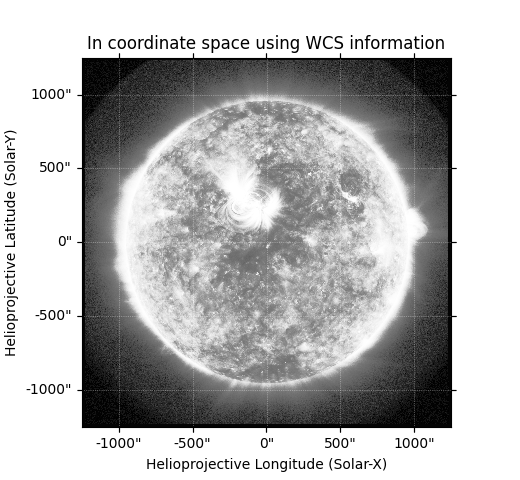
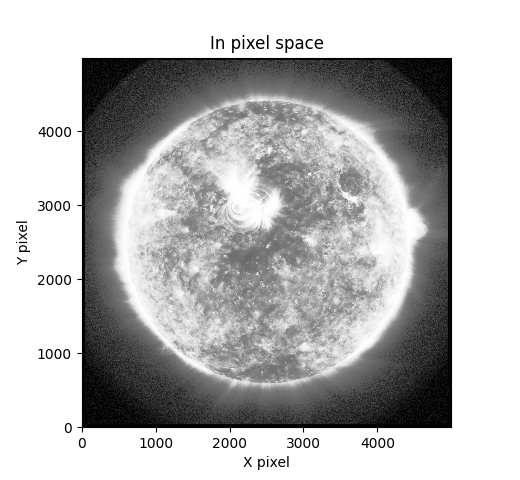
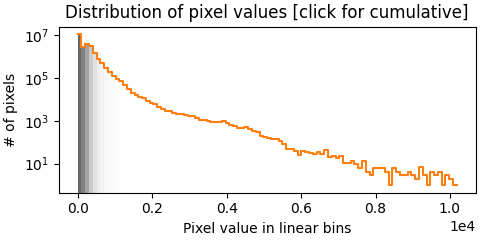
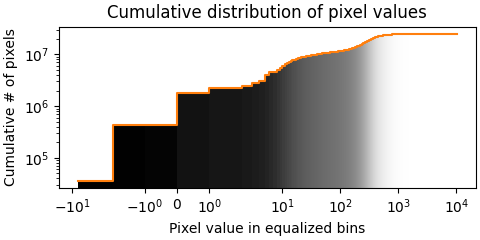

In [61]:
ref_map_full_disk

Let's identify the active region we are interested in.
This is an area of intense magnetic activity where the plasma trapped along magnetic field lines is heating and cooling.
We can visually locate the center of this region and a surrounding field of view.

In [62]:
ar_center = SkyCoord(Tx=-125*u.arcsec, Ty=250*u.arcsec, frame=ref_map_full_disk.coordinate_frame)

In [63]:
fov = (500, 500)*u.arcsec

In [64]:
bottom_left = SkyCoord(Tx=ar_center.Tx-fov[0]/2,
                       Ty=ar_center.Ty-fov[1]/2,
                       frame=ref_map_full_disk.coordinate_frame)

The blue cross indicates the center of the active region.
The white box represents the bounding box that denotes our entire region of interest.

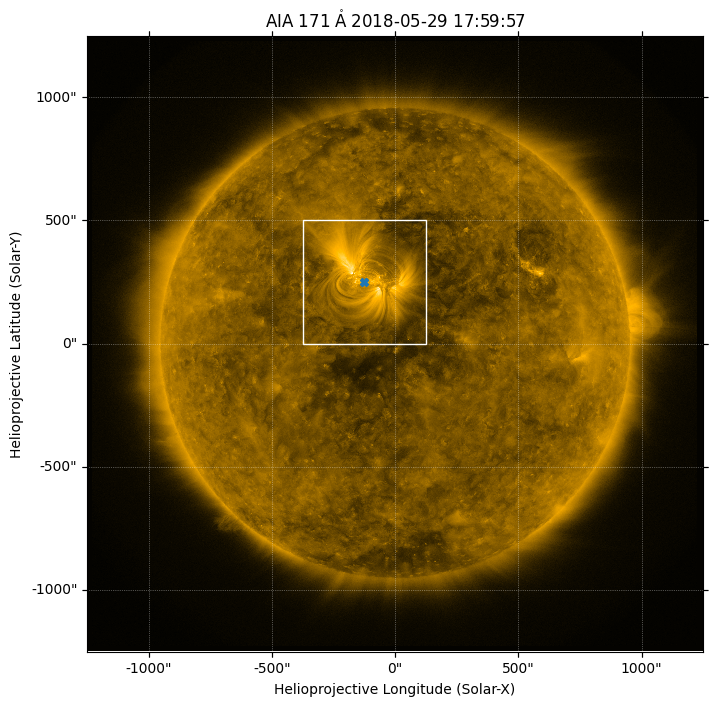

In [65]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(projection=ref_map_full_disk)
ref_map_full_disk.plot(axes=ax)
ref_map_full_disk.draw_quadrangle(bottom_left, width=fov[0], height=fov[1])
ax.plot_coord(ar_center, marker='X', color='C0')

We can now use these coordinates to create a cutout of submap from our larger full-disk map as we are only interested in studying a small region of the original map.

In [66]:
ref_map_cutout = ref_map_full_disk.submap(bottom_left, width=fov[0], height=fov[1])

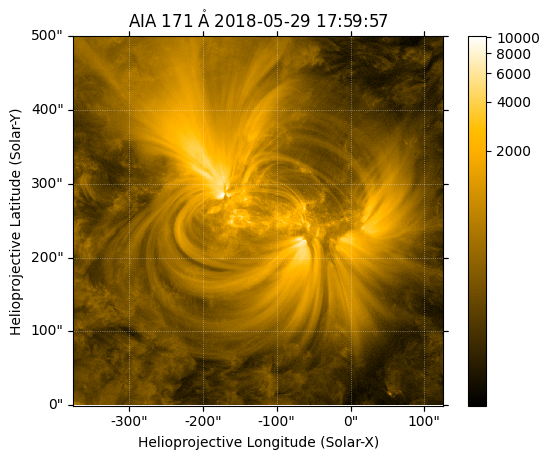

In [67]:
ref_map_cutout.peek()

## Loading Metadata

Now that we know what our region of interest is, we want to select the image data corresponding to that region of interest at each timestep using the URLs returned by our search.
To do this, we need to first build a Map for each file.

At its core, a map is just a data array plus a metata object.
To build a map, we require the metadata of each map to be in memory.

We'll define a function that just returns the header from each file and returns this to the RAM of our notebook environment.
The memory footprint of this is very small and fast to load so doing this eagerly is not an issue.

In [68]:
def get_header(filename):
    with astropy.io.fits.open(filename, use_fsspec=True, fsspec_kwargs={'anon': True}, lazy_load_hdus=True) as hdul:
        header = hdul[1].header
    return astropy.io.fits.Header(header)

In [69]:
all_headers = client.gather(client.map(get_header, q[0]['URL']))

## Building the Map

The data arrays, on the other hand, need to be loaded lazily as Dask arrays.
These are 5K by 5K arrays.
Let's first define a delayed function that returns the data array.

In [70]:
@dask.delayed
def get_data(filename):
    with astropy.io.fits.open(filename, use_fsspec=True, fsspec_kwargs={'anon': True}) as hdul:
        data = hdul[1].data
    return data

Fortunately, our map object works well with Dask arrays so we can just create a Dask array from our delayed object and build all of our maps lazily using just our headers and list of files.

In [71]:
def map_from_delayed(delayed_array, header, dtype):
    shape = (header['NAXIS2'], header['NAXIS1'])
    array = dask.array.from_delayed(delayed_array, shape, dtype=dtype,)
    return sunpy.map.Map(array, header)

In [72]:
full_disk_maps = [map_from_delayed(get_data(f), h, ref_map_full_disk.data.dtype) for f, h in zip(q[0]['URL'], all_headers)]

In [73]:
full_disk_maps[0]

Observatory,SDO
Instrument,AIA 3
Detector,AIA
Measurement,171.0 Angstrom
Wavelength,171.0 Angstrom
Observation Date,2018-05-29 11:59:57
Exposure Time,2.0001629999999997 s
Dimension,[5000. 5000.] pix
Coordinate System,helioprojective
Scale,[0.5 0.5] arcsec / pix
Reference Pixel,[2499.5 2499.5] pix


## Exposure Time Normalization

Each time the telescope records an image, the shutter is left open for some amount of time known as the exposure time.
This value is stored in metadata of the map.

In general, this amount can vary from one image to the next so we must normalize each individual image according to that exposure time.
This is just a matter of dividing each image through by the exposure time which gives us back a new map whose data is now normalized.

In [74]:
normalized_maps = [sunpy.map.Map(m.data/m.exposure_time.to_value('s'), m.meta) for m in full_disk_maps]

In [75]:
normalized_maps[0]

Observatory,SDO
Instrument,AIA 3
Detector,AIA
Measurement,171.0 Angstrom
Wavelength,171.0 Angstrom
Observation Date,2018-05-29 11:59:57
Exposure Time,2.0001629999999997 s
Dimension,[5000. 5000.] pix
Coordinate System,helioprojective
Scale,[0.5 0.5] arcsec / pix
Reference Pixel,[2499.5 2499.5] pix


## Aligning and Selecting FOV with Reprojection

Due to the rotation of the Sun, the active region rotates across the field of view of SDO (approximately located at Earth).
Thus, we must account for this rotation when selecting our region of interest from the full-disk maps.
We do this by *reprojecting* each image to the field of view of our cutout region that we initially selected at the midpoint of our observing interval.
This has the effect of rotating our region of interest appropriately either forward or backward in time.

All of this can be accomplished using the `reproject` package, an Astropy-affiliated package, combined with `sunpy.coordinates` to properly account for the differential rotation of the Sun.

In [76]:
@dask.delayed
def reproject_array(input_array, input_wcs, target_wcs):
    with propagate_with_solar_surface():
        out_array = reproject_adaptive((input_array, input_wcs),
                                       target_wcs,
                                       shape_out=target_wcs.array_shape,
                                       roundtrip_coords=False,
                                       return_footprint=False)
    return out_array

As before, we can build a Dask array from this delayed function and build a list of our reprojected maps.

In [77]:
def reproject_map(input_map, target_wcs):
    delayed_array = reproject_array(input_map.data, input_map.wcs, target_wcs)
    target_header = target_wcs.to_header()
    target_header['NAXIS1'] = target_wcs.array_shape[1]
    target_header['NAXIS2'] = target_wcs.array_shape[0]
    return map_from_delayed(delayed_array, target_header, input_map.data.dtype)

In [78]:
reprojected_maps = [reproject_map(m, ref_map_cutout.wcs) for m in normalized_maps]

In [79]:
reprojected_maps[0]

Observatory,
Instrument,
Detector,
Measurement,Unknown
Wavelength,Unknown
Observation Date,2018-05-29 17:59:57
Exposure Time,Unknown
Dimension,[1002. 1002.] pix
Coordinate System,helioprojective
Scale,[0.00013889 0.00013889] deg / pix
Reference Pixel,[7.505e+02 5.000e-01] pix


Note that if we look at the first and last maps in our list, we see that both remain in the center of our field of view.

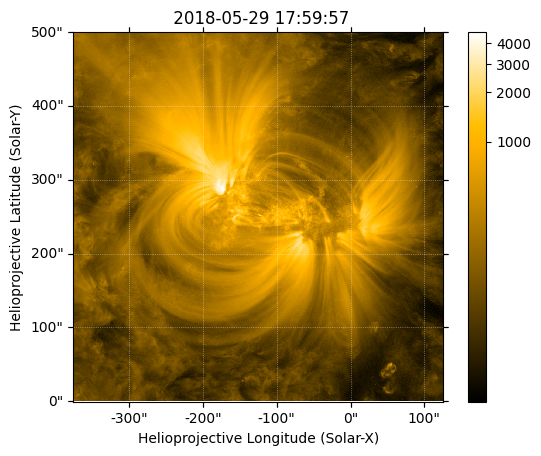

In [80]:
reprojected_maps[0].peek(**ref_map_cutout.plot_settings)

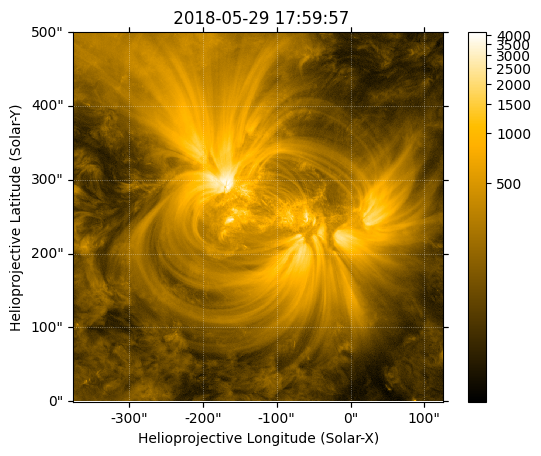

In [81]:
reprojected_maps[-1].peek(**ref_map_cutout.plot_settings)

## Stacking Images

Finally, we want to stack all of these aligned images into a single data cube.
Let's define a function that stacks all of our aligned cutouts together, interpolates them to a common time axis, and then returns an `NDCube` object.
The SunPy-affiliated `ndcube` package provides data structures for handling $N$-dimensional datacubes with an associated WCS.

In [82]:
def stack_and_interpolate(cutouts, time_cutouts, time_common):
    # Stack data
    data_stacked = np.stack([c.data for c in cutouts], axis=0)
    # Rechunk along time axis
    data_stacked = data_stacked.rechunk(chunks=data_stacked.shape[:1]+(300, 300))
    # Interpolate to common time
    f_interp = lambda y: interp1d(time_cutouts.to_value('s'), y, axis=0, kind='linear', fill_value='extrapolate')
    data_interp = dask.array.map_blocks(
        f_interp(time_common.to_value('s')),
        data_stacked,
        chunks=time_common.shape+data_stacked.chunks[1:],
        dtype=data_stacked.dtype
    )
    # Add the time axis to our coordinate system
    combined_wcs = cutouts[0].wcs.to_header()
    combined_wcs['CTYPE3'] = 'TIME'
    combined_wcs['CUNIT3'] = 's'
    combined_wcs['CDELT3'] = np.diff(time_common)[0].to_value('s')
    combined_wcs['CRPIX3'] = 1
    combined_wcs['CRVAL3'] = time_common[0].to_value('s')
    combined_wcs = astropy.wcs.WCS(combined_wcs)

    return ndcube.NDCube(data_interp, wcs=combined_wcs, unit=cutouts[0].unit, meta=cutouts[0].meta)

Because each filter of the AIA telescope does not take an observation at exactly the same time, we need to interpolate each data cube corresponding each channel to a common time array.
This common time array will be shared across all wavelengths.

In [83]:
cadence = 4*u.min
delta_time = time_end - time_start
time_common = time_start + np.arange(0, delta_time.to_value('s'), cadence.to_value('s')) * u.s

We can extract the time of each map from the map metadata.

In [84]:
time_171 = astropy.time.Time([m.date for m in normalized_maps])

In [85]:
cube_171 = stack_and_interpolate(reprojected_maps,
                                     (time_171 - time_common[0]).to('s'),
                                     (time_common-time_common[0]).to('s'))

Note that the stacked datacube is a Dask array with chunks oriented along the time axis.

In [86]:
cube_171.data

dask.array<<scipy.interpolate._interpolate.interp1d object at, shape=(180, 1002, 1002), dtype=float64, chunksize=(180, 300, 300), chunktype=numpy.ndarray>

Slicing our NDCube yields still another NDCube, still backed by a Dask array.

In [87]:
sliced_cube = cube_171[:,400:600,400:600]

In [88]:
sliced_cube

NDCube
------
Dimensions: [180. 200. 200.] pix
Physical Types of Axes: [('time',), ('custom:pos.helioprojective.lon', 'custom:pos.helioprojective.lat'), ('custom:pos.helioprojective.lon', 'custom:pos.helioprojective.lat')]
Unit: None
Data Type: float64

In [89]:
sliced_cube.data

dask.array<getitem, shape=(180, 200, 200), dtype=float64, chunksize=(180, 200, 200), chunktype=numpy.ndarray>

Operations on the cube still preserve "laziness"!

In [90]:
ts_averaged = sliced_cube.rebin((1, 200, 200), operation=np.mean)

In [91]:
ts_averaged

NDCube
------
Dimensions: [180.   1.   1.] pix
Physical Types of Axes: [('time',), ('custom:pos.helioprojective.lon', 'custom:pos.helioprojective.lat'), ('custom:pos.helioprojective.lon', 'custom:pos.helioprojective.lat')]
Unit: None
Data Type: float64

In [92]:
ts_averaged.data

dask.array<mean_agg-aggregate, shape=(180, 1, 1), dtype=float64, chunksize=(180, 1, 1), chunktype=numpy.ndarray>

<WCSAxes: ylabel='Data'>

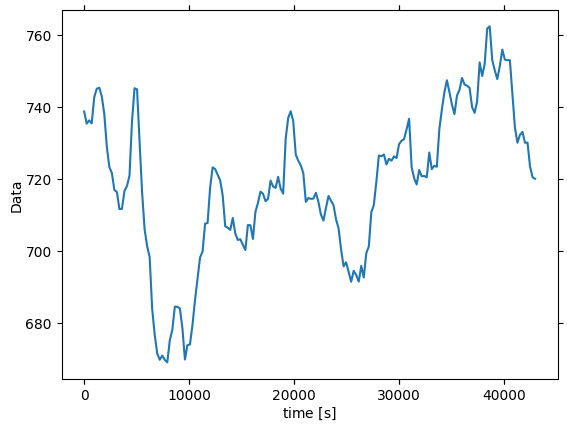

In [93]:
ts_averaged[:,0,0].plot()

## Now do this for another channel...

We now want to carry out all of these steps for another wavelength imaged by AIA: 193 Å. 
This channel is most sensitive to plasma around 2 MK.

To make this a bit easier, let's combine all of these steps we went through above into a single function.

In [94]:
def build_cutout_cube(file_urls, time_common, ref_map):
    all_headers = client.gather(client.map(get_header, file_urls))
    full_disk_maps = [map_from_delayed(get_data(f), h, np.int32) for f,h in zip(file_urls, all_headers)]
    normalized_maps =[sunpy.map.Map(m.data/m.exposure_time.to_value('s'), m.meta) for m in full_disk_maps]
    reprojected_maps = [reproject_map(m, ref_map.wcs) for m in normalized_maps]
    time_maps = astropy.time.Time([m.date for m in normalized_maps])
    cube = stack_and_interpolate(reprojected_maps,
                                 (time_maps - time_common[0]).to('s'),
                                 (time_common-time_common[0]).to('s'))
    return cube

Now, let's search for all 193 Å images in the same interval.

In [95]:
q_193 = Fido.search(
    a.Time(time_start, time_end),
    a.Wavelength(193*u.angstrom),
    heliocloud_attrs.Dataset('AIA'),
)

And use them to build a datacube for this wavelength.

In [96]:
cube_193 = build_cutout_cube(q_193[0]['URL'], time_common, ref_map_cutout)

In [97]:
cube_193.data

dask.array<<scipy.interpolate._interpolate.interp1d object at, shape=(180, 1002, 1002), dtype=float64, chunksize=(180, 300, 300), chunktype=numpy.ndarray>

## Time Lag Analysis

We now have a datacube for the entire active region as a function of time for both the 171 and 193 Å wavelengths on the same spatial and temporal grid.
Because these wavelengths are sensitive to plasma at very different temperatures, by analyzing how the intensity evolves in time in each channel, we can start to understand the thermodynamics of the solar atmosphere.

One way to do that is through a cross-correlation analysis.
The cross-correlation between two timeseries $A$ and $B$ is defined as,

$$
\mathcal{C}_{AB}(\tau) = \mathcal{F}^{-1}\left\{\mathcal{F}\{I_A(-t)\}\mathcal{F}\{I_B(t)\}\right\}
$$

where $\tau$ is the temporal offset between the two signals.
The *time lag* is the temporal offset that maximizes the cross-correlation between the two signals,

$$
\tau_{AB} = \arg\max_\tau\mathcal{C}_{AB}(\tau)
$$

The time lag between the 193 Å and 171 Å wavelengths then provides a proxy for how long it takes the plasma to cool from 2 MK to 1 MK.
Computing this in every pixel then gives us a map of the cooling plasma over the entire active region!

Fortunately, this calculation is already implemented in a Dask-friendly way in the SunPy-affiliated `sunkit-image` package which means that we can just pass our aligned arrays as Dask datacubes and this calculation will be added to our task graph.

In [98]:
tl_193_171 = time_lag(cube_193.data, cube_171.data, (time_common-time_common[0]).to('s'), [-6,6]*u.h)

In [99]:
tl_193_171

dask.array<mul, shape=(1002, 1002), dtype=float64, chunksize=(75, 1002), chunktype=astropy.Quantity>

Finally. let's visualize this map of cooling plasma!
By plotting it in matplotlib, we kick off the computation of our graph, starting all the way from our unprocessed data to our final science result.

In [100]:
tl_map = ndcube.NDCube(tl_193_171, wcs=ref_map_cutout.wcs)

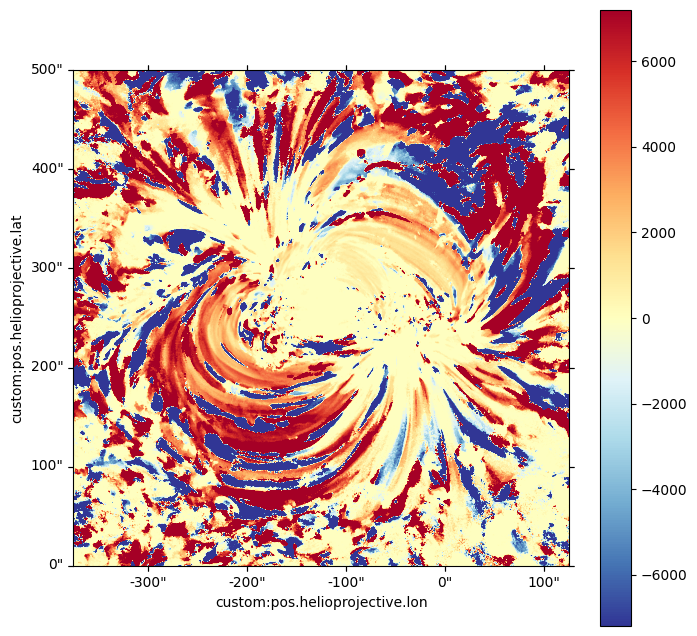

In [101]:
plt.figure(figsize=(8,8))
tl_map.plot(cmap='RdYlBu_r', vmin=-7200, vmax=7200)
plt.colorbar()